<a href="https://colab.research.google.com/github/qeqlik/react-youtube/blob/main/docs/tutorials/google/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The Cirq Developers

In [ ]:
!pip install torch torchvision torchaudio




In [ ]:
!lspci | grep -i nvidia


/bin/bash: line 1: lspci: command not found


In [ ]:
!nvidia-smi


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!apt-get update -y
!apt-get install -y nvidia-driver-535
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,351 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,666 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
print("CUDA Kullanılabilir mi?", torch.cuda.is_available())
print("Mevcut Cihaz:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "GPU Bulunamadı")


Looking in indexes: https://download.pytorch.org/whl/cu121
CUDA Kullanılabilir mi? False
Mevcut Cihaz: GPU Bulunamadı


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install cycle_gan_pytorch


ERROR: Could not find a version that satisfies the requirement cycle_gan_pytorch (from versions: none)
ERROR: No matching distribution found for cycle_gan_pytorch


In [2]:
from google.colab import files
import zipfile
import os

# ZIP dosyanı yükle
uploaded = files.upload()

# ZIP dosyasının adını buraya yaz
zip_path = "resimler.zip"

# ZIP dosyasını çıkart
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Tüm resimler "dataset" klasörüne açılacak

print("Dosyalar çıkarıldı!")


Saving resimler.zip to resimler.zip
Dosyalar çıkarıldı!


Dataset Path: dataset/train
Veri setindeki dosyalar: ['1001.jpg', '275.jpg', '379.jpg', '115.jpg', '45.jpg', '944.jpg', '911.jpg', '928.jpg', '820.jpg', '770.jpg', '133.jpg', '793.jpg', '236.jpg', '1002.jpg', '446.jpg', '17.jpg', '796.jpg', '207.jpg', '14.jpg', '489.jpg', '1028.jpg', '1029.jpg', '31.jpg', '267.jpg', '507.jpg', '916.jpg', '747.jpg', '419.jpg', '362.jpg', '57.jpg', '731.jpg', '530.jpg', '769.jpg', '1021.jpg', '534.jpg', '221.jpg', '118.jpg', '30.jpg', '1004.jpg', '371.jpg', '713.jpg', '625.jpg', '461.jpg', '262.jpg', '981.jpg', '844.jpg', '290.jpg', '533.jpg', '863.jpg', '40.jpg', '513.jpg', '877.jpg', '963.jpg', '1096.jpg', '395.jpg', '136.jpg', '734.jpg', '745.jpg', '1011.jpg', '777.jpg', '830.jpg', '818.jpg', '473.jpg', '889.jpg', '925.jpg', '463.jpg', '840.jpg', '168.jpg', '629.jpg', '587.jpg', '939.jpg', '337.jpg', '1059.jpg', '93.jpg', '614.jpg', '727.jpg', '428.jpg', '527.jpg', '431.jpg', '258.jpg', '560.jpg', '912.jpg', '817.jpg', '949.jpg', '1053.jpg', '276.jpg'

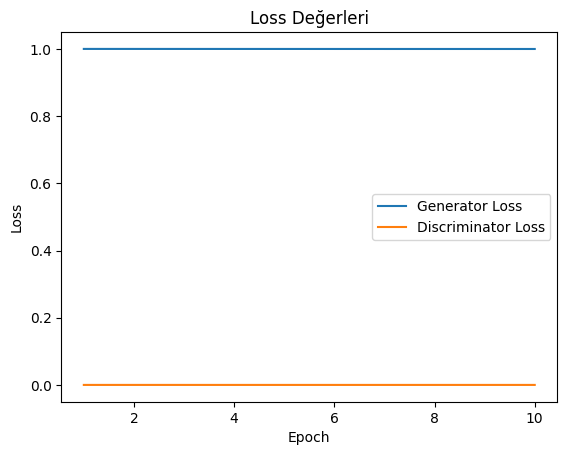

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt

# 📂 Tüm resimlerin bulunduğu klasör
dataset_path = "dataset/train"  # Eğer zip açıldıysa burada olacak
import os
print("Dataset Path:", dataset_path)
print("Veri setindeki dosyalar:", os.listdir(dataset_path))


# 📌 Özel Dataset Sınıfı
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith((".jpg", ".jpeg", ".png"))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# 🖼️ Görüntüleri işleme ve veri artırma (Data Augmentation)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 📌 Dataset ve DataLoader oluştur
dataset = ImageDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 🎨 CycleGAN Generator (Gelişmiş Model)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# 🔍 CycleGAN Discriminator (Basit Model)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 📌 Model Tanımlama ve GPU kullanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 🎯 Kayıp Fonksiyonu ve Optimizasyon
criterion = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.02, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.02, betas=(0.5, 0.999))

# 🏋️ Modeli Eğitme
epochs = 10  # 10 epoch eğiteceğiz

# Loss değerlerini depolamak için listeler
losses_G = []
losses_D = []

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    start_time = time.time()  # Epoch başında zaman ölçümünü başlat

    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)  # GPU'ya taşıyoruz
        batch_size = real_images.size(0)

        # ✅ Discriminator Eğitimi
        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, torch.ones_like(output_real).to(device))  # GPU uyumu ekledik

        fake_images = generator(real_images)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, torch.zeros_like(output_fake).to(device))  # GPU uyumu ekledik

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # ✅ Generator Eğitimi
        optimizer_G.zero_grad()
        output_fake = discriminator(fake_images)
        loss_G = criterion(output_fake, torch.ones_like(output_fake).to(device))  # GPU uyumu ekledik
        loss_G.backward()
        optimizer_G.step()

        # 🎯 Log Yazdır
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(dataloader)}], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

    # Epoch bitiminde geçen süreyi yazdırma
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} tamamlandı, Süre: {epoch_time:.2f} saniye")

    # Loss değerlerini kaydet
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    # 📸 Her epoch sonunda görseli kaydet
    save_image(fake_images, f"generated_image_epoch_{epoch+1}.jpg")

    # Modeli kaydet
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

# 🎉 Eğitim tamamlandı
print("🎉 Eğitim tamamlandı!")

# 🎨 Loss Grafiği Çizme
plt.plot(range(1, epochs+1), losses_G, label='Generator Loss')
plt.plot(range(1, epochs+1), losses_D, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Değerleri')
plt.legend()
plt.show()


In [4]:
from google.colab import files
files.download("generated_image.jpg")


FileNotFoundError: Cannot find file: generated_image.jpg

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import shutil

destination_folder = "/content/drive/My Drive/CycleGAN_Images"

# Eğer klasör yoksa oluştur
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Tüm görüntüleri taşı
for file in os.listdir():
    if file.startswith("generated_image_epoch_") and file.endswith(".jpg"):
        shutil.move(file, os.path.join(destination_folder, file))

print("Tüm resimler Google Drive'a kaydedildi!")


Tüm resimler Google Drive'a kaydedildi!


# Notebook template

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/colab"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/tutorials/google/colab.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/tutorials/google/colab.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/colab.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

## Setup


## Make a copy of this template

You will need to have access to Quantum Computing Service before running this colab.

This notebook can serve as a starter kit for you to run programs on Google's quantum hardware.  You can download it using the directions below, open it in colab (or Jupyter), and modify it to begin your experiments.

## How to download iPython notebooks from GitHub

You can retrieve iPython notebooks in the Cirq repository by
going to the [docs/ directory](https://github.com/quantumlib/Cirq/tree/main/docs).  For instance, this Colab template is found [here](https://github.com/quantumlib/Cirq/blob/main/docs/tutorials/google/colab.ipynb). Select the file that you would like to download and then click the *Raw* button in the upper-right part of the window:

<img src="https://raw.githubusercontent.com/quantumlib/Cirq/main/docs/images/colab_github.png" alt="GitHub UI button to view raw file">

This will show the entire file contents.  Right-click and select *Save as* to save this file to your computer.  Make sure to save to a file with a `.ipynb` extension (you may need to select *All files* from the format dropdown instead of *text*). You can also get to this Colab's [raw content directly](https://raw.githubusercontent.com/quantumlib/Cirq/main/docs/tutorials/google/colab.ipynb)

You can also retrieve the entire Cirq repository by running the following command in a terminal that has `git` installed:

```
git checkout https://github.com/quantumlib/Cirq.git
```

## How to open Google Colab

You can open a new Colab notebook from your Google Drive window or by visiting the [Colab site](https://colab.research.google.com/notebooks/intro.ipynb).  From the Colaboratory site, you can use the menu to upload an iPython notebook:

<img src="https://raw.githubusercontent.com/quantumlib/Cirq/main/docs/images/colab_upload.png" alt="Google Colab's upload notebook entry in File menu.">

This will upload the ipynb file that you downloaded before.  You can now run all the commands, modify it to suit your goals, and share it with others.

### More Documentation Links

* [Quantum Engine concepts](../../google/concepts.ipynb)
* [Quantum Engine documentation](../../google/engine.md)
* [Cirq documentation](https://quantumai.google/cirq)
* [Colab documentation](https://colab.research.google.com/notebooks/welcome.ipynb)


## Authenticate with Quantum Computing Service and install Cirq

For details of authentication and installation, please see [Get started with Quantum Computing Service](start.ipynb).

Note:  The below code will install the latest stable release of Cirq.  If you need the latest and greatest features and don't mind if a few things aren't quite working correctly, you can install the pre-release version of `cirq` using `pip install cirq~=1.0.dev` instead of `pip install cirq` to get the most up-to-date features of Cirq.

1. Enter the Cloud project ID you'd like to use in the `project_id` field.
2. Then run the cell below (and go through the auth flow for access to the project id you entered).

<img src="https://raw.githubusercontent.com/quantumlib/Cirq/main/docs/images/run-code-block.png" alt="Quantum Engine console">

## Create an Engine variable

The following creates an engine variable which can be used to run programs under the project ID you entered above.

## Example